# Cosmo Tutorial
This is a brief guide on how to use GWFish to produce cosmological inferences

In [1]:
#! pip install -q git+https://github.com/janosch314/GWFish.git
#! pip install -q lalsuite
#! pip install -q corner
#! pip install -q dill
#! pip install -q getdist

### Import packages

In [2]:
# suppress warning outputs for using lal in jupuyter notebook
import warnings 
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

import GWFish.modules as gw
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import corner
import numpy as np
import pandas as pd
import json
import os
import dill as pickle
from getdist import loadMCSamples
import getdist.plots as gdplt
from scipy.integrate import simpson
import astropy.cosmology as apcosmo
from scipy.interpolate import interp1d

In [3]:
# plotting settings
matplotlib.rcParams.update({
    'font.size': 10,
    'axes.labelsize': 10,
    'axes.titlesize': 16,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 14
})

# Let's create suitable catalog of events

In [4]:
from_deg_to_rad = np.pi/180.

In [5]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
        print('Directory created: ', path)
    else:
        pass
        #print('Directory already exists: ', path)

In [6]:
ns = 80
np.random.seed(42)

## unphysical approach

In [7]:
# data = {}
# data['redshift'] = np.random.uniform(0.001, 3, ns)
# mass_1_source = np.random.uniform(low = 1.1, high = 2.1, size = ns)
# mass_2_source = np.random.uniform(low = 1.1, high = 2.1, size = ns)
# data['luminosity_distance'] = np.ones(len(data['redshift']))#dL_z(data['redshift'])
# data['ra'] = np.random.uniform(0., 2 * np.pi, ns)
# data['dec'] = np.arcsin(np.random.uniform(-1., 1., ns))
# data['psi'] = np.random.uniform(0., np.pi, ns)
# data['phase'] = np.random.uniform(0., 2 * np.pi, ns)
# data['geocent_time'] = np.random.uniform(1577491218, 1609027217, ns)

## physical approach

In [8]:
def md_merger_rate(z, alphaF, betaF, CF, norm):
    return norm * (1+z)**alphaF / (1+((1+z)/CF)**betaF) 

def sampling_redshift_bns(redshift_dict, NSamples, seed):

    #choosing the cosmology
    keys = list(redshift_dict.keys())
    if 'Om0' in keys:  
        Om0 = redshift_dict['Om0']
    else:              
        Om0 = None
    if 'Ode0' in keys: 
        Ode0 = redshift_dict['Ode0']
    else:              
        Ode0 = None
    if 'H0' in keys:   
        H0 = redshift_dict['H0']
    else:              
        H0 = None

    if None in (Om0,Ode0,H0):
        cosmo = apcosmo.Planck18
    else:
        cosmo = apcosmo.LambdaCDM(H0=H0, Om0=Om0, Ode0=Ode0)

    # Initializing the random number generator    
    rng = np.random.default_rng(seed)

    # uniform redshift distribution
    if redshift_dict['model'] == 'uniform':
        if redshift_dict['default'] == True:
            zmin = 0.
            zmax = 10.
        else:
            zmin = redshift_dict['zmin']
            zmax = redshift_dict['zmax']

        z_vec = rng.uniform(low=zmin, high=zmax, size=NSamples)

    # uniform in comoving volume
    elif redshift_dict['model'] == 'uniform_comoving_volume':
        if redshift_dict['default'] == True:
            zmin = 0.
            zmax = 10.
        else:
            zmin = redshift_dict['zmin']
            zmax = redshift_dict['zmax']

        nzs = max(5001, 50 * int((zmax-zmin)) + 1)
        zs = np.linspace(zmin,zmax,nzs)
        z_dist = (lambda z: ((4.*np.pi*cosmo.differential_comoving_volume(z).value)/(1.+z)))(zs)
        window_cdf = np.array([simpson(z_dist[:i],zs[:i]) for i in range(1,nzs+1)]) / simpson(z_dist,zs)
        inv_window_cdf = interp1d(window_cdf, zs)
        z_vec = inv_window_cdf(rng.random(NSamples))

    # Madau-Dickinson merger rate, with fiducial parameters come from the GWBENCH package
    elif redshift_dict['model'] == 'madau_dickinson':
        if redshift_dict['default'] == True:
            zmin   = 0.
            zmax   = 10.
            alphaF = 1.803219571
            betaF  = 5.309821767
            CF     = 2.837264101
            norm   = 8.765949529
        else:
            zmin   = redshift_dict['zmin']
            zmax   = redshift_dict['zmax']
            alphaF = redshift_dict['alphaF']
            betaF  = redshift_dict['betaF']
            CF     = redshift_dict['CF']
            norm   = redshift_dict['norm']

        nzs = max(5001, 50 * int((zmax-zmin)) + 1)
        zs = np.linspace(zmin,zmax,nzs)
        z_dist = (lambda z: ((md_merger_rate(z,alphaF,betaF,CF,norm)*4.*np.pi*cosmo.differential_comoving_volume(z).value)/(1.+z)))(zs)
        window_cdf = np.array([simpson(z_dist[:i],zs[:i]) for i in range(1,nzs+1)]) / simpson(z_dist,zs)
        inv_window_cdf = interp1d(window_cdf, zs)
        z_vec = inv_window_cdf(rng.random(NSamples))

    DL_vec = cosmo.luminosity_distance(z_vec).value

    return z_vec, DL_vec

In [9]:
redshift_dict = {
    'model' : 'madau_dickinson',
    'default' : True
}

z_samples, dL_samples = sampling_redshift_bns(redshift_dict, ns, seed=42)

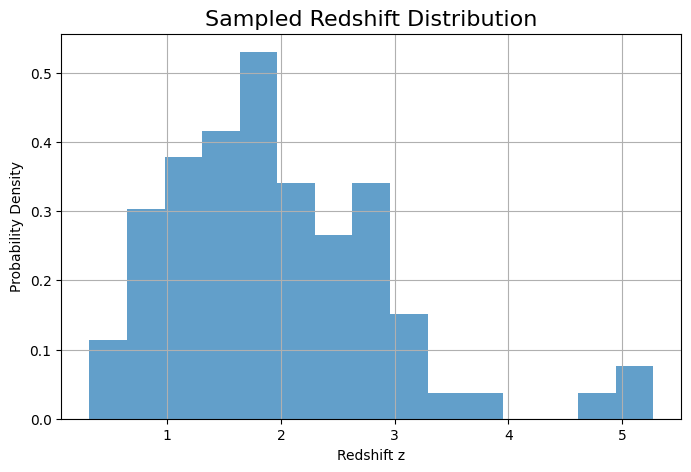

In [10]:
#plot z_samples
plt.figure(figsize=(8,5))
plt.hist(z_samples, bins=15, density=True, alpha=0.7)
plt.xlabel('Redshift z')
plt.ylabel('Probability Density')
plt.title('Sampled Redshift Distribution')
plt.grid()
plt.show()

In [11]:
# sort the two masses so that m1>m2 and create M_chirp and q

mass_1_source = np.random.uniform(low = 1.1, high = 2.1, size = ns)
mass_2_source = np.random.uniform(low = 1.1, high = 2.1, size = ns)

mass_1_det = mass_1_source * (1+z_samples)
mass_2_det = mass_2_source * (1+z_samples)

aux_mass = mass_1_det
mass_1_det = np.maximum(aux_mass, mass_2_det)
mass_2_det = np.minimum(aux_mass, mass_2_det)

In [12]:
#create only visible GRBs

a, b, c, d = -1., np.cos(175/180*np.pi), np.cos(5/180*np.pi), 1.

# Specify relative probabilities
prob = np.array([b-a, d-c])
prob = prob/prob.sum() # Normalize to sum up to one

r = []
for ii in range(ns):
    r.append(np.random.choice([np.arccos(np.random.uniform(a, b)), np.arccos(np.random.uniform(c, d))], p=prob))

theta_data = np.array(r)

In [13]:
data = {}
data['redshift'] = z_samples
data['mass_ratio'] = mass_2_det/mass_1_det
data['chirp_mass'] = (mass_1_det * mass_2_det)**(3/5) / (mass_1_det + mass_2_det)**(1/5)
data['luminosity_distance'] = dL_samples
data['ra'] = np.random.uniform(0., 2 * np.pi, ns)
data['dec'] = np.arcsin(np.random.uniform(-1., 1., ns))
data['theta_jn'] = theta_data
data['psi'] = np.random.uniform(0., np.pi, ns)
data['phase'] = np.random.uniform(0., 2 * np.pi, ns)
data['geocent_time'] = np.random.uniform(1577491218, 1609027217, ns)

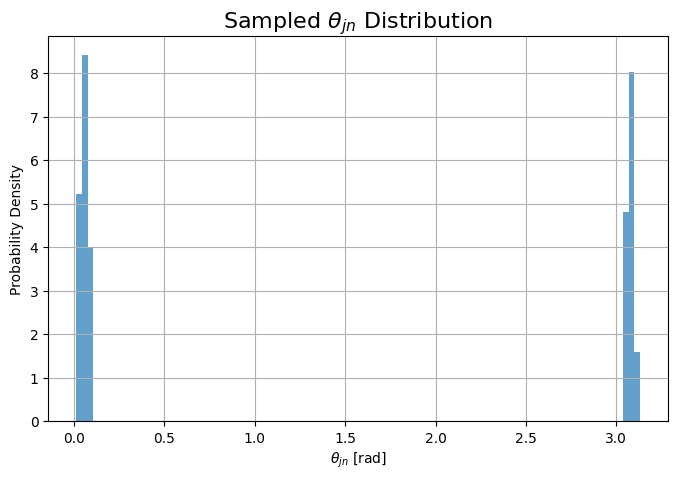

In [14]:
# plot theta_jn
plt.figure(figsize=(8,5))
plt.hist(data['theta_jn'], bins=100, density=True, alpha=0.7)
plt.xlabel(r'$\theta_{jn}$ [rad]')
plt.ylabel('Probability Density')
plt.title(r'Sampled $\theta_{jn}$ Distribution')
plt.grid()
plt.show()

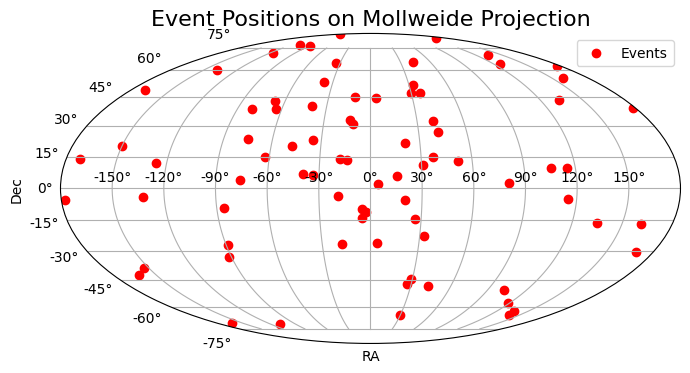

In [15]:
plt.figure(figsize=(8, 5)) 
ra_rad = data['ra'].astype(float) 

# Shift RA from [0, 2pi] to [-pi, pi] for mollweide 
ra_rad = np.where(ra_rad > np.pi, ra_rad - 2 * np.pi, ra_rad) 

dec_rad = data['dec'].astype(float) 

ax = plt.subplot(111, projection='mollweide') 
ax.scatter(ra_rad, dec_rad, marker='o', color='red', label='Events') 

ax.grid(True) 
ax.set_xlabel('RA') 
ax.set_ylabel('Dec') 
ax.set_title('Event Positions on Mollweide Projection') 
plt.legend() 
plt.show()

In [16]:
data2save = pd.DataFrame(data=data)
data2save.head(5)

,redshift,mass_ratio,chirp_mass,luminosity_distance,ra,dec,theta_jn,psi,phase,geocent_time
0,2.649630,0.751127,5.394567,22404.316540,0.647946,0.261777,0.052906,2.211932,0.126111,1.607083e+09
1,1.641375,0.840340,4.319453,12502.973009,5.670907,0.402258,0.083231,0.669047,2.023683,1.583207e+09
2,3.149753,0.781060,5.840114,27580.417558,3.174594,-0.091044,3.092178,0.428424,1.328567,1.579588e+09
3,2.341390,0.684987,4.074958,19290.559269,5.192785,0.257968,3.074520,0.045693,2.057727,1.600863e+09
4,0.802911,0.890173,2.088720,5185.199461,2.010931,0.169438,0.076745,1.101403,0.752488,1.595608e+09


In [17]:
catalog_folder = os.path.join(os.getcwd(), "output")

create_dir(catalog_folder)

data2save.to_hdf(catalog_folder + f'/grb_events.hdf5', mode='w', key='root')


# Let's use GWFish! We will first use raw GWFish and then apply physical priors

In [18]:
np.random.seed(42)

In [19]:
population = 'BNS'
networks = '[[0]]' 
detectors = ['ET']
networks_ids = json.loads(networks)

ConfigDet = ' '

threshold_SNR =  (0., 8.)

waveform_model = 'IMRPhenomHM'

fisher_parameters = ['chirp_mass', 'mass_ratio', 'luminosity_distance', 'theta_jn', 'psi', 'phase'] 

corner_lbs = ['$\mathcal{M}_c$ $[M_{\odot}]$', '$q$', '$d_L$ [Mpc]', '$\iota$ [rad]', '$\Psi$ [rad]', '$\phi$ [rad]']


In [20]:
parameters = pd.read_hdf(catalog_folder + f'/grb_events.hdf5')
parameters.head(5)

,redshift,mass_ratio,chirp_mass,luminosity_distance,ra,dec,theta_jn,psi,phase,geocent_time
0,2.649630,0.751127,5.394567,22404.316540,0.647946,0.261777,0.052906,2.211932,0.126111,1.607083e+09
1,1.641375,0.840340,4.319453,12502.973009,5.670907,0.402258,0.083231,0.669047,2.023683,1.583207e+09
2,3.149753,0.781060,5.840114,27580.417558,3.174594,-0.091044,3.092178,0.428424,1.328567,1.579588e+09
3,2.341390,0.684987,4.074958,19290.559269,5.192785,0.257968,3.074520,0.045693,2.057727,1.600863e+09
4,0.802911,0.890173,2.088720,5185.199461,2.010931,0.169438,0.076745,1.101403,0.752488,1.595608e+09


In [21]:
kwargs_network = {'detector_ids': detectors}


path_out_GWFish = os.path.join(os.getcwd(), "output", "gwfish_results")

if threshold_SNR is not None:
    kwargs_network['detection_SNR'] = threshold_SNR
if ConfigDet!= ' ':
    kwargs_network['config'] = ConfigDet

network = gw.detection.Network(**kwargs_network)

gw.fishermatrix.analyze_and_save_to_txt(network = network,
                                        parameter_values  = parameters,
                                        fisher_parameters = fisher_parameters, 
                                        sub_network_ids_list = networks_ids,
                                        population_name = population,
                                        waveform_model = waveform_model,
                                        save_path = path_out_GWFish,
                                        save_matrices = True,
                                        use_duty_cycle = True)

100%|██████████| 80/80 [00:09<00:00,  8.09it/s]


# Let's apply physical priors

In [22]:
# join detector entries with underscore
detectors_str = '_'.join(detectors)
det = detectors_str  # alias used later in the notebook

In [23]:
file_path = path_out_GWFish + f'/Errors_{detectors_str}_{population}_SNR{int(threshold_SNR[1])}.txt'


# Read header line (strip leading '#' or '//' and commas) and load data
with open(file_path, 'r') as f:
    header = f.readline().lstrip('#/ \t').replace(',', ' ')
cols = header.split()

means = pd.read_csv(file_path, names=cols, skiprows=1, delim_whitespace=True)

cov_path = os.path.join(path_out_GWFish, f'inv_fisher_matrices_{detectors_str}_{population}_SNR{int(threshold_SNR[1])}.npy')
cov_matrix = np.load(cov_path)

lbs_mns = fisher_parameters

In [24]:
z_thr = 0.13
check_z_thr = means[means['redshift'] < z_thr]

In [25]:
CornerPlot = False
plotPosteriors = False
DensityPlot = False
PlotPeculiar = False

# if check_z_thr is empty then skip

if check_z_thr.empty:
    include_vp = False
else:
    include_vp = True

## Example of Applications

See Figure 1 in [**Cozzumbo, et al. 2024**](https://iopscience.iop.org/article/10.1088/1475-7516/2025/05/021/pdf)





In [26]:
mns = means[lbs_mns]
NN = len(mns)
N = 100_000
zmax = max(means['redshift'])

m1min = 1.1
m2min = 1.1
m1max = 2.5 * (1+zmax)
m2max = 2.5 * (1+zmax)

event_list = []
z_list  = []
density_list = []
skipped_events = []
posterior_list = []
dl_inject = []
Ddl_inject = []

save_density = None

min_array = np.array([0.,     0.01, 0.,      0.,    0.,    0.      ])
max_array = np.array([100.,   1.,   np.inf,  np.pi, np.pi, 2*np.pi ])


In [27]:
#from GWFish.modules.priors import *

from priors_mine import *
from scipy.stats import norm

In [28]:
mother_dir = os.getcwd()

In [ ]:
# for each event we proceed to the truncation and then to the prior evaluation and posterior sampling from a physically motivated prior-informed likelihood

for event in tqdm(np.arange(NN)):

    mns_ev = mns.iloc[event].to_numpy()
    cov_ev = cov_matrix[event, :, :]
    rng = np.random.default_rng(seed=100)

    fisher_samples = pd.DataFrame(rng.multivariate_normal(mns_ev, cov_ev, N), columns = fisher_parameters)
    
    # TRUNCATED SAMPLING

    try:
        with warnings.catch_warnings():
            warnings.simplefilter("error")  # Convert warnings into exceptions
            
            samples_truncated_mvn = get_truncated_likelihood_samples(
                fisher_parameters, mns_ev, cov_ev, N, 
                min_array=min_array, max_array=max_array
            )

    except Warning as w:  # Catch warnings
        print(f"Warning in truncated evaluation: {w}")
        skipped_events.append([means['redshift'][int(event)]])
        continue  # Skip to the next iteration

    except Exception as e:  # Catch other exceptions
        print(f"Error in truncated evaluation: {e}")
        skipped_events.append([means['redshift'][int(event)]])
        continue


    priors_dict = get_default_priors_dict(fisher_parameters) 

    # Chirp mass prior


    # Luminosity distance prior
    priors_dict['luminosity_distance']['prior_type'] = "uniform_in_comoving_volume_and_source_frame"
    
    priors_dict['luminosity_distance']['lower_prior_bound'] = 10


    priors_dict['luminosity_distance']['upper_prior_bound'] = 50000


    priors_dict['chirp_mass']['prior_type'] ='uniform_in_component_masses_chirp_mass'

    priors_dict['chirp_mass']['lower_prior_bound'] = ((m1min * m2min)**(3/5) / (m1min + m2min)**(1/5)) 

    priors_dict['chirp_mass']['upper_prior_bound'] = ((m1max * m2max)**(3/5) / (m1max + m2max)**(1/5))

    # theta_jn prior
    priors_dict['theta_jn']['prior_type'] = "uniform_in_sine"
    theta_jn_lowerbound = 0.
    theta_jn_upperbound = 5.

    if 0 < means['theta_jn'][event] < np.pi/2 :
        priors_dict['theta_jn']['lower_prior_bound'] = theta_jn_lowerbound*np.pi/180.
                    
    else:
        priors_dict['theta_jn']['lower_prior_bound'] = (180-theta_jn_upperbound)*np.pi/180


    if 0 < means['theta_jn'][event] < np.pi/2 :
        priors_dict['theta_jn']['upper_prior_bound'] = theta_jn_upperbound*np.pi/180.
                    
    else:
        priors_dict['theta_jn']['upper_prior_bound'] = (180-theta_jn_lowerbound)*np.pi/180


    # PRIOR EVALUATION and POSTERIOR SAMPLING

    try:
        samples_from_posterior = get_posteriors_samples(fisher_parameters, samples_truncated_mvn, N, priors_dict = priors_dict)
        
    except Exception as e:
        print('Error in the prior evaluation:', e)
        skipped_events.append([means['redshift'][int(event)]])
        continue

    z_save = means['redshift'][int(event)]

                    
    if CornerPlot:

        CORNER_KWARGS = dict(
                            bins = 50, # number of bins for histograms
                            smooth = 0.99, # smooths out contours. 
                            plot_datapoints = False, # choose if you want datapoints
                            truth_color='red',
                            label_kwargs = dict(fontsize = 16), # font size for labels
                            show_titles = True, #choose if you want titles on top of densities.
                            title_kwargs = dict(fontsize = 12), # font size for title
                            plot_density = True,
                            title_quantiles = [0.16, 0.5, 0.84],  # add quantiles to plot densities for 1d hist
                            levels = (1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)), # 1, 2 and 3 sigma contours for 2d plots
                            fill_contours = True, #decide if you want to fill the contours
                            max_n_ticks = 3, # set a limit to ticks in the x-y axes.
                            title_fmt=".2f"
                            )
        
        fig = corner.corner(fisher_samples, labels = corner_lbs, truths = mns_ev, color = 'black', alpha = 0.5, **CORNER_KWARGS)
        old_fig = corner.corner(samples_truncated_mvn, labels = corner_lbs, truths = mns_ev, color = 'orange', alpha = 0.5, **CORNER_KWARGS, fig = fig)
        new_fig = corner.corner(samples_from_posterior, labels = corner_lbs, truths = mns_ev, color = 'red', alpha = 0.5, **CORNER_KWARGS, fig = fig)
        

        plot_dir = f"{mother_dir}/check_images/corner"
        create_dir(plot_dir)
        plt.savefig(plot_dir + f'/cornerplot_{event}.pdf',dpi=600, bbox_inches='tight', facecolor='white')

        plt.close()

    if plotPosteriors:

        # Set font size for ticks
        matplotlib.rc('xtick', labelsize=8)
        matplotlib.rc('ytick', labelsize=8)

        # Create subplots
        fig, axs = plt.subplots(2, 3, figsize=(10, 10))

        # Histogram plots
        params = fisher_parameters
        positions = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]

        for param, pos in zip(params, positions):
            counts, edges, _ = axs[pos].hist(samples_from_posterior[param].to_numpy(), bins=50)
            axs[pos].set_xlabel(param, fontsize=8)
            
            # Plot injected values
            axs[pos].axvline(x=mns_ev[params.index(param)], color='red', label='injected')
            
            # Plot new mean values
            axs[pos].axvline(x=samples_from_posterior[param].mean(), color='orange', label='new mean')
            
            # Plot max posterior values
            mode_index = np.argmax(counts)
            axs[pos].axvline(x=0.5 * (edges[mode_index] + edges[mode_index + 1]), color='lightgreen', label='max posterior')

        # Adjust layout and add legend
        plt.legend(bbox_to_anchor=(1., 0.5), loc='center left', fontsize=8)
        plt.tight_layout()

        # Save plot
        target_dir = f"{mother_dir}/check_images/posteriors"
        create_dir(target_dir)
        plt.savefig(f'{target_dir}/GW_posteriors_{event}.pdf', dpi=600, bbox_inches='tight', facecolor='white')

        # Close figure
        plt.close()


    # here we save the posterior samples for the luminosity distance only, to be used in the cosmological analysis
    # we use getdist kde interpolation, that is fast and flexible
    # SAVE ALL POSTERIORS
    
    weights, edges, _ = plt.hist(samples_from_posterior['luminosity_distance'].to_numpy(), bins=100, density=True)
    plt.close()

    out_path_posteriors = f"{mother_dir}/output/posteriors"
    create_dir(out_path_posteriors)
    final_samples = np.zeros((3,len(samples_from_posterior['luminosity_distance'].to_numpy())))
    final_samples[0, :] = 1
    final_samples[2,:] = samples_from_posterior['luminosity_distance'].to_numpy()
    # CREATE PARAMFILE
    param_list = ['d_L']
    paramfile = [param_list[ii] + '\t' + param_list[ii] for ii in range(len(param_list))]
    np.savetxt(out_path_posteriors + f'/posteriors_tmp.paramnames', paramfile, fmt='%s')
    
    np.savetxt(out_path_posteriors+ f'/posteriors_tmp.txt', np.transpose(final_samples), fmt='%i %.6e %.6e')
    settings = {'smooth_scale_1D' : 0.3}
    sample_getdist=gdplt.loadMCSamples(out_path_posteriors + f'/posteriors_tmp', settings=settings)
    density = gdplt.MCSamples.get1DDensityGridData(sample_getdist, 0)

    z_list.append(z_save)
    
    density_list.append(density)
    if DensityPlot:
        plt.rc('font', size=25, family='serif')
        plt.rc('text', usetex=True)
        fig = plt.figure(figsize=(10, 10))
        xx = np.linspace(min(samples_from_posterior['luminosity_distance'].to_numpy()), max(samples_from_posterior['luminosity_distance'].to_numpy()),300)
        plt.hist(samples_from_posterior['luminosity_distance'].to_numpy(), bins=100, density=True, alpha=0.7)
        plt.plot(xx, max(weights)*density(xx), lw=3, label= 'Interpolating density')
        #plt.plot(xx, max(weights)*density2(xx), label= 'Interpolating density bw=0.3')
        plt.legend()

        plot_dir =  f"{mother_dir}/check_images/density"
        create_dir(plot_dir)
        plt.tight_layout()
        plt.xlabel(r'$z$')
        plt.ylabel(r'$p(d_L)$')
        plt.savefig(plot_dir + f'/densityplot_{z_save}_{event}.pdf',dpi=600, bbox_inches='tight', facecolor='white')
        #plt.show()
        plt.close()

    # just to save the posteriors
    posterior_list.append(samples_from_posterior['luminosity_distance'].to_numpy())
    dl_inject.append(means['luminosity_distance'].to_numpy()[event])
    Ddl_inject.append(means['err_luminosity_distance'].to_numpy()[event])


    
out_path_kde = f"{mother_dir}/output/kde"
create_dir(out_path_kde)

# if there are elements with z < z_thr, then we apply the correction

if include_vp:
    print('Peculiar velocity correction on going')
    print('Starting the peculiar velocity analysis\n')
    # include vp correction
    
    dt = {}
    dt['z'] = z_list
    dt['posterior'] = posterior_list
    dt['kde'] = density_list
    dt['dl'] = dl_inject
    dt['Ddl'] = Ddl_inject
    dataframe_data = pd.DataFrame(data=dt)                
    sorted_df = dataframe_data.sort_values(by=['z'])
    idx_cycle = np.where(np.array(sorted_df['z']) <= z_thr)[0]


    mean_vp = 300.
    sigma_vp = 200.
    
    if len(idx_cycle) != 0:
        
        for idx, ii in enumerate(idx_cycle):
            
            gw_samples = sorted_df['posterior'].to_numpy()[ii]
            gw_density = sorted_df['kde'].to_numpy()[ii]
            z_event = sorted_df['z'].to_numpy()[ii]
            dl= sorted_df['dl'].to_numpy()[ii]
            Ddl= sorted_df['Ddl'].to_numpy()[ii]
            rng = np.random.RandomState(ii)
            vp_rms = rng.normal(loc=mean_vp, scale=50) 
            sigma_vp = rng.normal(loc=sigma_vp, scale=50)
            
            sigma_dL_vp = np.median(gw_samples) * sigma_vp / (vp_rms + c * z_event) 
            #first estimate of the peculiar velocity distribution impedence when combined by 
            #simple quadrature sum because we need dL_values to be big enough
            peculiar_Ddl = np.sqrt((Ddl)**2 + sigma_dL_vp**2)
            if dl-3*peculiar_Ddl <=0:
                min_bound = 0
            else:
                min_bound = dl-3*peculiar_Ddl
            dL_values = np.linspace(min_bound, dl+3*peculiar_Ddl, 10000)
            # Generate a Gaussian distribution for the peculiar velocity part
            v_p_distribution = norm(loc=np.median(gw_samples), scale=sigma_dL_vp)
            # Calculate the PDF of the peculiar velocity part
            pdf_vp = v_p_distribution.pdf(dL_values)
            # Calculate the PDF of the combined distribution by convolving the PDFs
            combined_pdf = np.convolve(pdf_vp, gw_density(dL_values), mode='same')
            # Normalize the combined PDF
            combined_pdf /= np.sum(combined_pdf)
            histogram, bin_edges = np.histogram(dL_values, bins=10000, weights=combined_pdf)
            combined_samples = np.random.choice((bin_edges[:-1] + bin_edges[1:]) / 2, size=1_000_000, p= np.abs(histogram) / np.sum(histogram))
            samp = np.zeros((3,len(combined_samples)))
            samp[0, :] = 1
            samp[2,:] = combined_samples
            np.savetxt(out_path_posteriors+ f'/posteriors_tmp.txt', np.transpose(samp), fmt='%i %.6e %.6e')
            
            settings = {'smooth_scale_1D' :0.3}
            getdist=gdplt.loadMCSamples(out_path_posteriors+ f'/posteriors_tmp', settings=settings)
            density_final = gdplt.MCSamples.get1DDensityGridData(getdist, 0)
            
            dataframe_data['kde'] = density_final
            
            #Plot the combined distribution
            if PlotPeculiar:
                plt.figure(figsize=(10, 10))

                plt.plot(dL_values, density_final(dL_values), label=r'Combined kde with Gaussian $v_{\mathrm{peculiar}}$', color='green')
                plt.plot(dL_values, gw_density(dL_values), label='Old kde', color='red')
                plt.xlabel(r'$d_L$')
                plt.ylabel('Density')
                plt.title(f'Event at $z$={z_event} | $z_t$={z_thr} $v_p$={vp_rms:.2f} $\sigma_v$={sigma_vp:.2f}')
                plt.legend(loc='upper right')
                plt.xlim(np.min(gw_samples), np.max(gw_samples))

                plot_dir = f"{mother_dir}/check_images/peculiar_velocity"
                create_dir(plot_dir)
                plt.savefig(plot_dir + f'/peculiar_velocity_{idx}.pdf',dpi=600, bbox_inches='tight', facecolor='white')
                #plt.show()
                plt.close()
        
        density_vp = list(dataframe_data['kde'])
        
        save_density = [z_list, density_list, dl_inject, Ddl_inject, density_vp]

else:
    save_density = [z_list, density_list, dl_inject, Ddl_inject]
    
cosmology_save = 'LCDM_Planck18'
create_dir(out_path_kde + f'/{det}_{cosmology_save}_fiducial')

with open(out_path_kde + f'/{det}_{cosmology_save}_fiducial/{det}_{cosmology_save}_fiducial.pkl', 'wb') as handle:

    pickle.dump(save_density, handle, protocol=pickle.HIGHEST_PROTOCOL)

os.remove(out_path_posteriors + f'/posteriors_tmp.txt')


print(f'Max z seen: {max(z_list)}')
print('Skipped events [name, redshift]:', skipped_events)

# Let's play with cosmology!

## we generate a likelihood and we run a cosmological MCMC with [cobaya](https://cobaya.readthedocs.io/en/latest/#)

## this is interfaced with a Einstein-Boltzmann solver called [CLASS](http://class-code.net)

In [30]:
#! pip install -q cobaya
#! pip install -q openmpi
#! pip install -q "mpi4py>=3"

In [31]:
import cobaya
from cobaya.run import run
from cobaya.yaml import yaml_load_file
import yaml

In [32]:
# installing CLASS
os.system(f"cobaya-install classy -p {mother_dir}/myclass")

[install] Installing external packages at '/Users/andreacozzumbo/GSSIprojects/acme_tutorials/cosmo_tutorial/myclass'
[install] The installation path has been written into the global config file: /Users/andreacozzumbo/Library/Application Support/cobaya/config.yaml

classy

[install] Checking if dependencies have already been installed...
[install] External dependencies for this component already installed.
[install] Doing nothing.

* Summary * 

[install] All requested components' dependencies correctly installed at /Users/andreacozzumbo/GSSIprojects/acme_tutorials/cosmo_tutorial/myclass


0

In [33]:
cosmology = 'LCDM_Planck18'

In [34]:
cosmo_data_path = os.path.join(mother_dir, "output", "kde", f"{det}_{cosmology}_fiducial")
pt_path = os.path.join(mother_dir, "cosmo_MCMC")
class_path = os.path.join(mother_dir, "myclass", "code", "classy")
output_path_MCMC = os.path.join(mother_dir, "cosmo_MCMC", "chains", "test1", "test")

input_yaml_path = os.path.join(mother_dir, "cosmo_MCMC", "input", "test.yaml")

In [35]:
#input_file = f"{mother_dir}/cosmo_MCMC/input/input.yaml"

base_config = {
    "theory": {
        "classy": {
            "path": class_path,
            "ignore_obsolete": True
        }
    },
    "likelihood": {
        "likelihood.MMcosmology": {
            "data_directory": cosmo_data_path,
            "python_path": pt_path,
            "gw_network": "ET",         
            "grb_dataset": "fiducial",    
            "fiducial_cosmology": "LCDM_Planck18",
            "interpolation_method": "kde",
        }
    },
    "params": {
        "omega_b": {
            "value": 0.0224,
            "latex": r"\Omega_\mathrm{b} h^2"
        },
        
        "Omega_cdm": {
            "prior": {"min": 0.05, "max": 0.7},
            "ref": {"dist": "norm", "loc": 0.26, "scale": 0.01},
            "proposal": 0.05,
            "latex": r"\Omega_\mathrm{c}"
        },
        "H0": {
            "prior": {"min": 20, "max": 100},
            "ref": {"dist": "norm", "loc": 67, "scale": 0.5},
            "proposal": 1.,
            "latex": "H_\mathrm{0}"
        },
        "Omega_m": {"latex": r"\Omega_\mathrm{m}"},
        "Omega_Lambda": {"latex": r"\Omega_\Lambda"}
    },
    "sampler": {
        "mcmc": {
            "max_tries": 10000000,
            #"covmat": '/home/cozzumbo/AC/Theseus/covmat/covmat_all.covmat',
            "Rminus1_stop": 0.01
        }
    },
    "output": output_path_MCMC
}

with open(input_yaml_path, "w") as f:
    yaml.dump(base_config, f, sort_keys=False)

In [36]:
input_file = input_yaml_path


In [ ]:
os.system(f'mpirun -n 4 cobaya-run {input_file}')

In [43]:
from getdist import loadMCSamples
from getdist import plots

In [44]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False

In [45]:
settings = {'ignore_rows' : 0.3, 'smooth_scale_2D' : 0.5, 'smooth_scale_1D' : 0.5, 'contours':[0.68, 0.95, 0.997]}

In [46]:
samples = loadMCSamples(f"{mother_dir}/cosmo_MCMC/chains/test1/test", settings=settings)

In [47]:
truth_LCDM={'Omega_m':0.309, 'Omega_cdm':0.26, 'H0':67.81}

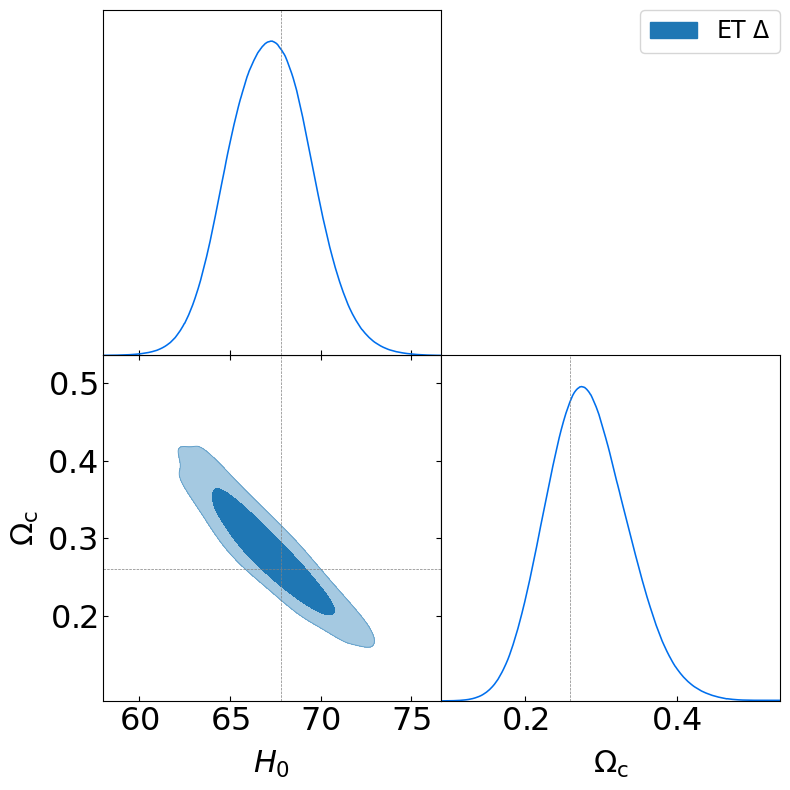

In [48]:

g = plots.get_subplot_plotter()
g.settings.subplot_size_inch = 4
g.settings.legend_fontsize = 17
g.settings.axes_fontsize = 23

g.settings.lab_fontsize = 22

g.triangle_plot([samples],
                params=['H0', 'Omega_cdm'] ,
                filled=[True],
                markers=truth_LCDM,
                colors=['C0'],
                legend_labels = [r"ET $\Delta$"],
                legend_loc='upper right',
                )

